<a href="https://colab.research.google.com/github/tomassams/tdt4173-machine-learning-project/blob/main/project_notebook_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


----

<div align="center">

<p align="center">

<h1> TDT4173 Project Assignment </h1>


<h1> A comparison of KNN and CNN for image classification in the gastrointestinal tract </h1>

<h2> KNN Implementation </h2>

</p>

</div>

----


*TDT4173 Machine Learning - NTNU, Fall 2020*

This notebook is one of two notebooks containing code used in the group project assignment. It is intended for use in Google Colab, and should run without issues there. However, most cells and commands can likely also run locally with minor adjustments. Things like CLI commands in the beginning (wget, unzip, etc) might be different based on your operating system.

The dataset used is the [Kvasir](https://datasets.simula.no/kvasir/) v2 dataset, containing classified images from the gastrointestinal tract.

Note that some parts are computation heavy - e.g. grid search in this notebook.

## 1 Setup and prerequisites

If any of these imports return an error, you might have to install them with pip. It can be done in the command line, or by executing it in a notebook code cell. An export of the environment requirements can be found in **requirements.txt**.

In [25]:
"""

    Import necessary libraries

"""
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab import files
import pandas as pd
import numpy as np
import os
import imutils
from imutils import paths
import cv2
import pickle 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [26]:
"""

    If the notebook is running in Colab, we want to download models and results
    when they are ready so they don't get lost if Colab times out.

    This global variable keeps track of that.

"""
RunningInCOLAB = 'google.colab' in str(get_ipython())

In [3]:
"""

    Set up our project folder structure

"""
def create_folder_unless_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_folder_unless_exists('data/raw')
create_folder_unless_exists('data/zip')
create_folder_unless_exists('models')
create_folder_unless_exists('results/knn_pixel_intensity')
create_folder_unless_exists('results/knn_color_histogram')

In [4]:
"""

    Download and unzip the dataset

    1. Downloads the zip-file with wget
    2. Unzips it into the root folder
    3. Moves it into the ./data/raw/ folder
    4. Moves the original zip file to the ./data/zip/ folder

    If you are not running in a Colab environment, you might need to do this manually.

    Folder structure should look like this after:

    |-- project root
    |   |--> ...
    |   |--> ...
    |   |--> data
    |        |--> zip
    |             |--> kvasir-dataset-v2.zip
    |        |--> raw
    |             |--> dyed-lifted-polyps
    |             |--> dyed-resection-margins
    |             |--> esophagitis
    |             |--> normal-cecum
    |             |--> normal-pylorus
    |             |--> normal-z-line
    |             |--> polyps
    |             |--> ulcerative-colitis

"""
!wget "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip"
!unzip -qq kvasir-dataset-v2.zip
!cp kvasir-dataset-v2/* data/raw -r
!cp kvasir-dataset-v2.zip data/zip -r
!rm kvasir-dataset-v2 -rf
!rm kvasir-dataset-v2.zip

--2020-11-14 14:29:43--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  16.9MB/s    in 3m 11s  

2020-11-14 14:32:55 (12.4 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



In [59]:
"""

    A helper utility to generate a pretty confusion matrix

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

"""
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          save_path=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    plt.colorbar()
    plt.rcParams.update({'font.size': 18})


    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=18, ha="right")
        plt.yticks(tick_marks, target_names, fontsize=18)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.autoscale()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=16)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

In [60]:
"""

    Utility function to plot, save and download the confusion matrix

"""
def display_confusion_matrix(y_pred, y_true, target_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, target_names, normalize=False, save_path=save_path)

    if RunningInCOLAB and save_path:
        files.download(save_path)

"""

    Utility function to print, save and download the classification report

"""
def display_classification_report(y_pred, y_true, target_names, save_path=None):
    cr = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    
    df = pd.DataFrame(cr).transpose()
    df = df.round(2)

    print(df)
    
    if save_path:
        df.to_csv(save_path, sep=';')
    
    if RunningInCOLAB and save_path:
        files.download(save_path)

## 2 Preprocessing and feature extraction

In [11]:
"""
    Collect all our image paths
"""
img_paths = list(paths.list_images('data/raw'))

# Print first 10 to see if they make sense
img_paths[:10]

['data/raw/dyed-resection-margins/d975df7c-e62b-4713-ab5c-db893fbdd541.jpg',
 'data/raw/dyed-resection-margins/ac6ec267-f5a2-406f-8084-fe7a0d3d4624.jpg',
 'data/raw/dyed-resection-margins/fe9ea687-f6aa-489b-aeee-40b5c18a4b5b.jpg',
 'data/raw/dyed-resection-margins/35a16221-32b7-46a7-9dc5-d6fc5b10544b.jpg',
 'data/raw/dyed-resection-margins/2a2592fc-4557-4276-8c96-d7ac1ee49d37.jpg',
 'data/raw/dyed-resection-margins/77d17e4b-4c82-4efe-952e-704f4c9440bb.jpg',
 'data/raw/dyed-resection-margins/66a97d94-5515-4ebd-b31b-ae6c628f3cf5.jpg',
 'data/raw/dyed-resection-margins/b2b619ce-1436-4d84-b2da-cb422e411658.jpg',
 'data/raw/dyed-resection-margins/3e5572da-42fc-47ea-804c-54e80e12dca4.jpg',
 'data/raw/dyed-resection-margins/1e5474f7-7076-4e60-9397-5bcb6a750660.jpg']

In [12]:
def image_to_feature_vector(image, size=(32, 32)):
	"""
		Feature extraction
		Resize an image and flatten it into a list of raw pixels
	"""
	return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):
	"""
		Feature extraction
		Extract a 3D color histogram in HSV color space
	"""
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,[0, 180, 0, 256, 0, 256])


	if imutils.is_cv2(): # special handling if OpenCV 2.4.X
		hist = cv2.normalize(hist)
	else:
		cv2.normalize(hist, hist)

	return hist.flatten()

In [13]:
def extract_dataset_features(img_paths, histogram_bins=(8,8,8), image_size=(32,32)):
	data_raw_pixels = []
	data_color_histogram = []
	data_labels = []

	# Go through all our image paths to extract features
	for (i, img_path) in enumerate(img_paths):

		# Extract image and label from path
		image = cv2.imread(img_path)
		label = img_path.split(os.path.sep)[-2].split(".")[0]

		# Extract raw pixel intensity features
		pixels = image_to_feature_vector(image, size=image_size)

		# Extract color histogram to characterize the color distribution of the pixels
		histogram = extract_color_histogram(image, bins=histogram_bins)

		# Update the raw images, features, and labels matricies respectively
		data_raw_pixels.append(pixels)
		data_color_histogram.append(histogram)
		data_labels.append(label)

		# Print an update every 1.000 images
		if i > 0 and i % 1000 == 0:
			print(f"processed {i}/{len(img_paths)}")

	print("Done processing")
 
	return (data_raw_pixels, data_color_histogram, data_labels)

data_raw_pixels, data_color_histogram, data_labels = extract_dataset_features(img_paths)

processed 1000/8000
processed 2000/8000
processed 3000/8000
processed 4000/8000
processed 5000/8000
processed 6000/8000
processed 7000/8000
Done processing


In [14]:
# retrieve unique labels and their indices to use later
unique_labels, unique_indices = np.unique(data_labels, return_index=True)

dyed-lifted-polyps


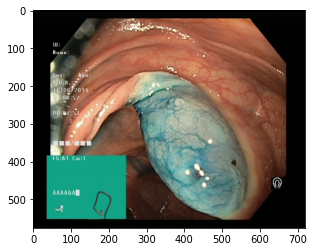

dyed-resection-margins


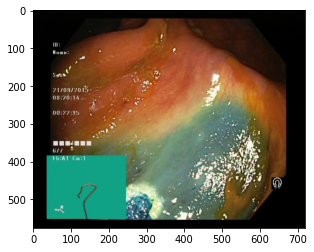

esophagitis


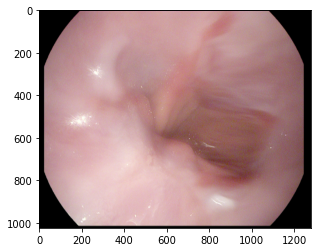

normal-cecum


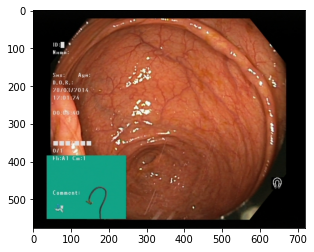

normal-pylorus


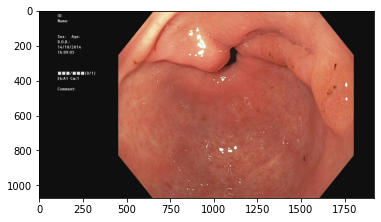

normal-z-line


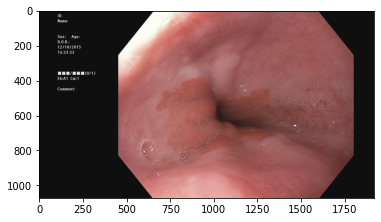

polyps


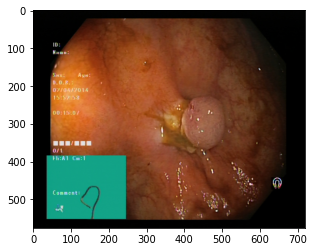

ulcerative-colitis


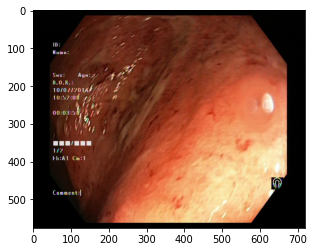

In [ ]:
# show an example of each class with image + label
for (i, index) in enumerate(unique_indices):
    path = img_paths[index]
    label = data_labels[index]

    img = cv2.imread(path)
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    print("=============")
    print(label)
    plt.imshow(rgb_image)
    plt.show()
    print("=============")

In [15]:
# Transform to numpy arrays
data_raw_pixels = np.array(data_raw_pixels)
data_color_histogram = np.array(data_color_histogram)
data_labels = np.array(data_labels)

In [16]:
print("data_raw_pixels: {:.2f}MB".format(data_raw_pixels.nbytes / (1024 * 1000.0)))
print("data_color_histogram: {:.2f}MB".format(data_color_histogram.nbytes / (1024 * 1000.0)))

data_raw_pixels: 24.00MB
data_color_histogram: 16.00MB


For the KNN algorithm we are doing two models: one based on pixel intensities, and one based on color histograms.

To find optimal hyperparameters we will be doing a grid search.

In [29]:
"""
    We will be performing a grid search based on this search grid.
"""
grid_params = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan']
}

## 3 Pixel intensity model

In [32]:
"""
    Split our dataset into training (80%) and testing (20%)
"""
x_train_raw_pixels, x_test_raw_pixels, y_train_raw_pixels, y_test_raw_pixels = train_test_split(data_raw_pixels, data_labels, test_size=0.2, random_state=42, stratify=data_labels)

### 3.1 Model training

In [33]:
"""
    Perform a grid search to find optimal hyperparameters

    Uses K-Fold Cross Validation with 5 folds.
    We will use the actual test set later for predicting on entirely unseen data for the model.
"""
print("Performing grid search on pixel intensity based features")
gs_rp = GridSearchCV(estimator=KNeighborsClassifier(), cv=5, param_grid=grid_params, verbose = 1, n_jobs = -1)
gs_results_rp = gs_rp.fit(x_train_raw_pixels, y_train_raw_pixels)

Performing grid search on pixel intensity based features
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 37.3min finished


In [35]:
"""
    Our best parameter results
"""
best_params_rp = gs_rp.best_params_ 
best_model_rp = gs_rp.best_estimator_
best_score_rp = gs_rp.best_score_

# Save model
pickle.dump(best_model_rp, open('models/knn_pixel_intensity.pkl', 'wb'))

# Download if we're in Colab
if RunningInCOLAB:
    files.download('models/knn_pixel_intensity.pkl') 

print(f"Best performing raw pixels model got {best_score_rp*100:.2f}% acc with params: {best_params_rp}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Best performing raw pixels model got 64.56% acc with params: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}


In [41]:
"""
    Output the results table
"""
gs_path = 'results/knn_pixel_intensity/knn_pixel_intensity_gridsearch.csv'

df_rp = pd.DataFrame(gs_rp.cv_results_).sort_values('rank_test_score')
df_rp = df_rp.round(4)
df_rp.to_csv(gs_path, sep=';')

if RunningInCOLAB:
    files.download(gs_path)

df_rp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,3.6285,0.0461,48.1034,0.8674,euclidean,11,distance,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.6344,0.6602,0.6516,0.6492,0.6328,0.6456,0.0105,1
4,3.6735,0.0484,48.0856,0.6725,euclidean,11,uniform,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.6289,0.6602,0.6516,0.6477,0.6367,0.6450,0.0110,2
3,3.6199,0.0933,47.2633,0.8950,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.6391,0.6531,0.6578,0.6344,0.6297,0.6428,0.0109,3
13,3.6415,0.0729,57.0032,0.4822,manhattan,11,distance,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6328,0.6609,0.6398,0.6422,0.6375,0.6427,0.0097,4
7,3.6717,0.0519,48.9691,0.8388,euclidean,19,distance,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.6203,0.6555,0.6461,0.6461,0.6234,0.6383,0.0139,5
12,3.5942,0.0538,57.3803,0.4919,manhattan,11,uniform,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6336,0.6500,0.6359,0.6367,0.6320,0.6377,0.0064,6
2,3.7019,0.0668,48.0431,1.0439,euclidean,5,uniform,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.6375,0.6438,0.6484,0.6336,0.6227,0.6372,0.0089,7
6,3.6287,0.0133,48.8144,0.8674,euclidean,19,uniform,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.6133,0.6516,0.6477,0.6469,0.6250,0.6369,0.0150,8
15,3.7029,0.1944,57.8210,1.1773,manhattan,19,distance,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",0.6312,0.6430,0.6305,0.6375,0.6391,0.6362,0.0048,9
11,3.6222,0.0311,55.9836,0.5913,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.6195,0.6578,0.6508,0.6195,0.6242,0.6344,0.0165,10


### 3.2 Model evaluation

In [42]:
"""
    If we are re-running the notebook, and want to avoid doing the whole grid search again,
    this cell creates the KNN models with the previously found top ranking hyperparameters.
"""
best_model_rp = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='distance')
best_model_rp.fit(x_train_raw_pixels, y_train_raw_pixels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')

In [43]:
"""
    Use model to predict on unseen test data
"""
predictions_rp = best_model_rp.predict(x_test_raw_pixels)

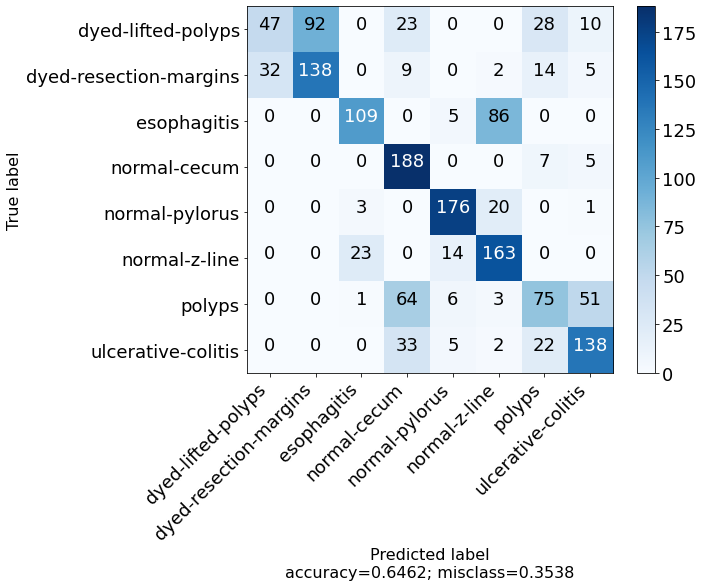

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                        precision  recall  f1-score  support
dyed-lifted-polyps           0.59    0.24      0.34   200.00
dyed-resection-margins       0.60    0.69      0.64   200.00
esophagitis                  0.80    0.55      0.65   200.00
normal-cecum                 0.59    0.94      0.73   200.00
normal-pylorus               0.85    0.88      0.87   200.00
normal-z-line                0.59    0.82      0.68   200.00
polyps                       0.51    0.38      0.43   200.00
ulcerative-colitis           0.66    0.69      0.67   200.00
accuracy                     0.65    0.65      0.65     0.65
macro avg                    0.65    0.65      0.63  1600.00
weighted avg                 0.65    0.65      0.63  1600.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
"""

    Evaluate the prediction results.

    Displays a Confusion Matrix and a Classification Report.
    These are also saved to the 'results' folder.

"""

display_confusion_matrix(
    y_pred=predictions_rp, 
    y_true=y_test_raw_pixels, 
    target_names=unique_labels, 
    save_path='results/knn_pixel_intensity/knn_pixel_intensity_confusion_matrix.png'
)

display_classification_report(
    y_pred=predictions_rp, 
    y_true=y_test_raw_pixels, 
    target_names=unique_labels, 
    save_path='results/knn_pixel_intensity/knn_pixel_intensity_classification_report.csv'
)

## 4 Color histogram model

In [45]:
"""
    Split our dataset into training (80%) and testing (20%)
"""
x_train_color_histogram, x_test_color_histogram, y_train_color_histogram, y_test_color_histogram = train_test_split(data_color_histogram, data_labels, test_size=0.25, random_state=42, stratify=data_labels)

### 4.1 Model training

In [46]:
"""
    Perform a grid search to find optimal hyperparameters

    Uses K-Fold Cross Validation with 5 folds.
    We will use the actual test set later for predicting on entirely unseen data for the model.
"""
print("Performing grid search on color histogram based features")
gs_ch = GridSearchCV(estimator=KNeighborsClassifier(), cv=5, param_grid=grid_params, verbose = 1, n_jobs = -1)
gs_results_ch = gs_ch.fit(x_train_color_histogram, y_train_color_histogram)

Performing grid search on color histogram based features
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.6min finished


In [ ]:
"""
    Our best parameter results
"""
best_params_ch = gs_ch.best_params_ 
best_model_ch = gs_ch.best_estimator_
best_score_ch = gs_ch.best_score_

# Save model
pickle.dump(best_model_ch, open('models/knn_color_histogram.pkl', 'wb'))

# Download if we're in Colab
if RunningInCOLAB:
    files.download('models/knn_color_histogram.pkl') 
    
print(f"Best performing color histogram model got {best_score_ch*100:.2f}% acc with params: {best_params_ch}")

In [48]:
"""
    Output the results table as well as saving it to file
"""
gs_path = 'results/knn_color_histogram/knn_color_histogram_gridsearch.csv'

df_ch = pd.DataFrame(gs_ch.cv_results_).sort_values('rank_test_score')
df_ch = df_ch.round(4)
df_ch.to_csv(gs_path, sep=';')

if RunningInCOLAB:
    files.download(gs_path)

df_ch

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.5472,0.0060,5.7139,0.2219,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.6925,0.6775,0.6867,0.6567,0.6750,0.6777,0.0122,1
13,0.5519,0.0094,5.8901,0.0513,manhattan,11,distance,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6867,0.6742,0.6875,0.6642,0.6692,0.6763,0.0093,2
15,0.5353,0.0128,6.1829,0.0435,manhattan,19,distance,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",0.6908,0.6742,0.6792,0.6625,0.6733,0.6760,0.0092,3
9,0.5485,0.0155,5.2575,0.0495,manhattan,3,distance,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.6867,0.6783,0.6758,0.6533,0.6767,0.6742,0.0111,4
10,0.5449,0.0064,5.5589,0.0464,manhattan,5,uniform,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.6942,0.6792,0.6825,0.6525,0.6600,0.6737,0.0153,5
8,0.5460,0.0212,5.3126,0.0612,manhattan,3,uniform,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.6892,0.6792,0.6758,0.6492,0.6675,0.6722,0.0134,6
12,0.5599,0.0360,6.0064,0.0736,manhattan,11,uniform,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6792,0.6733,0.6783,0.6567,0.6683,0.6712,0.0082,7
14,0.5482,0.0134,6.2508,0.0478,manhattan,19,uniform,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",0.6892,0.6675,0.6717,0.6558,0.6700,0.6708,0.0107,8
7,0.5470,0.0136,4.2525,0.0468,euclidean,19,distance,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.6808,0.6808,0.6625,0.6383,0.6450,0.6615,0.0176,9
5,0.5514,0.0144,3.9396,0.0526,euclidean,11,distance,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.6767,0.6750,0.6550,0.6383,0.6458,0.6582,0.0154,10


### 4.2 Model evaluation

In [50]:
"""
    If we are re-running the notebook, and want to avoid doing the whole grid search again,
    this cell creates the KNN models with the previously found top ranking hyperparameters.
"""
best_model_ch = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='distance')
best_model_ch.fit(x_train_color_histogram, y_train_color_histogram)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [54]:
"""
    Use model to predict on unseen test data
"""
predictions_ch = best_model_ch.predict(x_test_color_histogram)

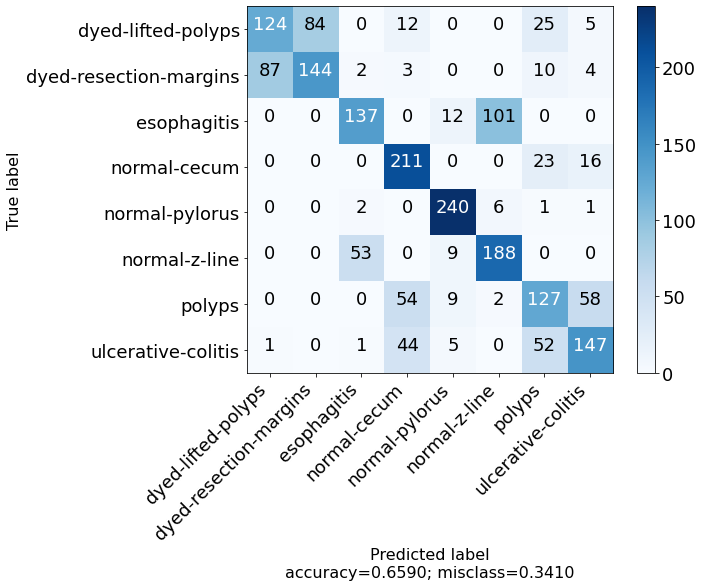

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                        precision  recall  f1-score  support
dyed-lifted-polyps           0.58    0.50      0.54   250.00
dyed-resection-margins       0.63    0.58      0.60   250.00
esophagitis                  0.70    0.55      0.62   250.00
normal-cecum                 0.65    0.84      0.74   250.00
normal-pylorus               0.87    0.96      0.91   250.00
normal-z-line                0.63    0.75      0.69   250.00
polyps                       0.53    0.51      0.52   250.00
ulcerative-colitis           0.64    0.59      0.61   250.00
accuracy                     0.66    0.66      0.66     0.66
macro avg                    0.66    0.66      0.65  2000.00
weighted avg                 0.66    0.66      0.65  2000.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
"""

    Evaluate the prediction results.

    Displays a Confusion Matrix and a Classification Report.
    These are also saved to the 'results' folder.

"""

display_confusion_matrix(
    y_pred=predictions_ch, 
    y_true=y_test_color_histogram, 
    target_names=unique_labels, 
    save_path='results/knn_color_histogram/knn_color_histogram_confusion_matrix.png'
)

display_classification_report(
    y_pred=predictions_ch, 
    y_true=y_test_color_histogram, 
    target_names=unique_labels, 
    save_path='results/knn_color_histogram/knn_color_histogram_classification_report.csv'
)